# Homework 5 Coding: Transport Modeling

For this coding assignment, you will write functions to calculate molar flux (and sometimes current density) for several given applications.  I will do much of the coding for you, at first, but then let you handle more and more of it, as we move along.

## Part I: Gas-phase diffusion in a PEMFC cathode.

For this scenario, we will model gas-phase transport in the gas diffusion layer (GDL) of a PEMFC cathode.

The cathode is 100 microns thick, with a porosity (gas-phase volume fraction) of 57%, with the tortuosity factor modeled using a Bruggeman coefficient of $n = -0.5$.

Use the Kozeny-Carman relationship to estimate the cathode GDL permeability, with a carbon particle diameter of 0.5 microns, and an average pore radius of 2 microns.

We will simulate transport at 60 C, where the dynamic viscosity of moist air is $\mu = 2.08\times 10^{-5}\,\frac{\rm kg}{\rm m-s}$.  The conditions at the two nodes are:

1. Node 1: in the gas flow channel
- Pressure = 1 atmosphere
- $X_{\rm O_2} = 0.21$
- $X_{\rm N_2} = 0.79$
- $X_{\rm H_2O} = 0.0$

2. Node 2: in the catalyst layer, where O$_2$ is consumed and H$_2$O is produced:
- Pressure = 100 kPa
- $X_{\rm O_2} = 0.16$
- $X_{\rm N_2} = 0.80$
- $X_{\rm H_2O} = 0.04$

The gas-phase species diffusion coefficients are:
- O$_2$: $2.438\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- N$_2$: $2.798\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- H$_2$O: $1.9\times 10^{-5}\,\frac{\rm m^2}{\rm s}$

In [3]:
import numpy as np

dY = 100e-6 # m
eps_g = 0.57
n_Brugg = -0.5
t_form = eps_g**(n_Brugg)

d_part = 0.5e-6
r_p = 2e-6

T = 333.15 # K
P_1 = 101325 # Pa
P_2 = 100000 # Pa

R = 8.3145 # J/mol-K
F = 96485  # C/mol equiv

# Species order: O2, N2, H2O_v
X_k_1 = np.array([0.21, 0.79, 0.0])
X_k_2 = np.array([0.16, 0.80, 0.04])
# molar Mass
X_m = np.array([31.99880/1000,28.0134/1000,18.01528/1000])

mu = 2.08e-5 #kg/m-s

D_k = np.array([2.438e-5, 2.798e-5, 1.9e-5]) #m2/s

### We are going to load all parameters into a series of Python dictionaries

We will pass these dictionaries to our function.  The dictionaries just make it more efficient then having 12 different input variables.

In [4]:
# State variables for node 1:
state1 = {'X_k':X_k_1, 'P':P_1, 'T':T}
# State variables for node 2:
state2 = {'X_k':X_k_2, 'P':P_2, 'T':T}

# Geometric and microstructure parameters:
geom = {'eps_g':eps_g, 'n_Brugg':n_Brugg, 'd_part':d_part, 'dY':dY}
# Gas properties
gas_props = {'D_k':D_k, 'mu':mu}

### Example for using values stored in dictionaries:

In [5]:
# To access a dictionary value:
print(gas_props['mu'])
print(state1['X_k'])
X_sum = sum(state1['X_k'])
print('The mole fractions sum to',X_sum)

2.08e-05
[0.21 0.79 0.  ]
The mole fractions sum to 1.0


## YOUR CODE GOES HERE:

Create a function that calculates the species fluxes, given our input dictionaries.

The function must return an array `N_k` that provides the species molar fluxes in mol/m$^2$-s. 

In [6]:
from math import exp, log
N_k_test = D_k*mu*R*T*(state2['X_k']-state1['X_k'])

def pemfc_gas_transport(state1, state2, geom, gas_props):
    C_k_1 = state1['P']/(R*state1['T'])*state1['X_k']
    C_k_2 = state2['P']/(R*state1['T'])*state2['X_k']
    K_m = geom['eps_g']**3*geom['d_part']**2/(72*t_form*(1-geom['eps_g'])**2)
    V_conv = -K_m*(state2['P']-state1['P'])/dY/gas_props['mu']*((state2['X_k']+state1['X_k'])/2)
    D_k_eff = geom['eps_g']/t_form*gas_props['D_k']
    print(V_conv)
    V_diff = -D_k_eff*(state2['X_k']-state1['X_k'])/dY/((state1['X_k']+state2['X_k'])/2)
    print(V_diff)
    N_k = (C_k_1+C_k_2)/2*(V_conv+V_diff)
    return N_k

N_k_calc = pemfc_gas_transport(state1, state2, geom, gas_props)
print(N_k_calc)

[3.09426046e-04 1.32969571e-03 3.34514644e-05]
[ 0.02835595 -0.00151458 -0.16352941]
[ 0.19288891 -0.00534129 -0.11804866]


### Now calculate the fluxes between nodes 1 and 2 (you do not need to do anything; just run the cell)
### Then check your answers against mine:

In [7]:
N_k_calc = pemfc_gas_transport(state1, state2, geom, gas_props)

from matplotlib import pyplot as plt
width = 0.35
N_k_check = np.array([0.19913, -0.007275, -0.11794]) #mol/m2/s

fig, ax = plt.subplots()

labels = ['O2', 'N2', 'H2O']
x = np.arange(len(labels))

ax.bar(x+width/2,N_k_check,width)
ax.bar(x-width/2,N_k_calc,width)
ax.legend(['DeCaluwe\'s Answer','My Answer'],frameon=False)

ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylabel('Diffusion coefficient (m$^2$/s)',fontsize=14)
ax.set_xlabel('Species',fontsize=14)

[3.09426046e-04 1.32969571e-03 3.34514644e-05]
[ 0.02835595 -0.00151458 -0.16352941]


Text(0.5, 0, 'Species')

## Part II: Charged species transport in a liquid electrolyte:

Next we will calculate molar fluxes for a liquid electrolyte in a battery anode.  These calculations will be for electro-diffusion only - there is no convection!

The molar density of the electrolyte is assumed constant at 1100 moles per m$^3$

The temperature is 45$^\circ$C.

The electrolyte is LiPF$_6$, dissolved in a generic "solvent" molecule, with the following conditions:

1. Node 1:
- $X_{\rm Li^+} = 0.03$
- $X_{\rm PF^-_6} = 0.03$
- $X_{\rm Solvent} = 0.94$
- Electric potential $\phi_1 = 0.9$ V

2. Node 2:
- $X_{\rm Li^+} = 0.06$
- $X_{\rm PF^-_6} = 0.06$
- $X_{\rm Solvent} = 0.88$
- Electric potential $\phi_2 = 0.5$ V

The distance between the nodes is 30 microns, and the average diameter of the solid active material particles is 5 microns.  The anode porosity (electrolyte volume fraction) is 23%, and the tortuosity is characterized by a Bruggeman coefficient of -0.5.

In [8]:
C_elyte = 1100 #mol/m3

F = 96485    # Faraday's constant, C/kmol equivalent charge\n

# Species order: Li+, PF6-, solvent
X_k_1 = np.array([0.03, 0.03, 0.94])
X_k_2 = np.array([0.06, 0.06, 0.88])

z_k = np.array([1., -1., 0.])

T = 318.  #K

dY = 30e-6

D_k = np.array([1.52e-10, 0.25e-10, 1e-12])

phi_1 = 0.9
phi_2 = 0.5

d_part = 5e-6

eps_elyte = .23
n_brugg = -0.5

t_form = eps_elyte**(n_brugg)

## ENTER CODE HERE 

### to Create the Necessary Dictionaries. We will call the states just 's1' and 's2', this time:

In [9]:
s1 = {'X_k':X_k_1, "phi":phi_1}
s2 = {'X_k':X_k_2, "phi":phi_2}

geom = {'eps_e':eps_elyte, 'n_b':n_brugg, 'd_p':d_part, 'dY':dY }
e_pars = {'z_k':z_k, 'D_k':D_k, "C_e":C_elyte}

## NOW CREATE YOUR FLUX-CALCULATING FUNCTION:

In [10]:
def electrolyte_transport(s1, s2, geom, e_pars):
    D_k_eff = geom['eps_e']/t_form*e_pars['D_k']
    C_avg = (s1['X_k']*e_pars['C_e']+s2['X_k']*e_pars['C_e'])/2
    D_mig = D_k_eff*C_avg*e_pars['z_k']*F/(R*T)
    g_X =(s2['X_k']-s1['X_k'])/dY
    g_avg =((s1['X_k']+s2['X_k'])/2)
    N_k = - D_k_eff*C_avg*g_X/g_avg - D_mig*(s2['phi']-s1['phi'])/dY
    return N_k

N_k_calculated = electrolyte_transport(s1,s2, geom, e_pars)

Now we loop over a range of Node 2 electric potentials.  We use the fluxes to calculate the current density:
\begin{equation}
i = F\sum_k z_kN_k
\end{equation}

In [11]:
dPhi = np.linspace(0,1.1,25)
currents = np.zeros_like(dPhi)
N_k = np.zeros((len(dPhi), len(z_k)))


for j, phi in enumerate(dPhi):
    s2['phi'] = phi
    N_k[j,:] = electrolyte_transport(s1,s2, geom, e_pars)
    currents[j] = np.dot(z_k,N_k[j,:])*F


## Plot the currents and check them against mine.
(You do not need to enter anything)
### For what potential is the current equal to zero?

Zero current at dPhi =  0.8868918122866205


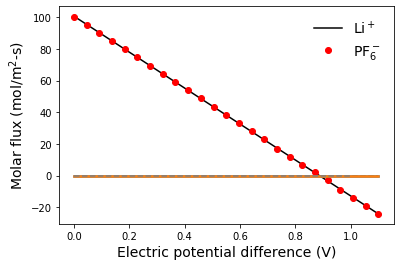

In [12]:
current_check = np.array([100.,  95.,  90.,  85.,  80.,  75.,  69.,
                          64.,  59.,  54.,  49.,  43.,  38.,  33.,
                          28.,  23.,  17.,  12.,   7.,   2.,  -3.,
                          -9.,    -14., -19., -24.])

plt.plot(dPhi, currents, 'k')
plt.plot(dPhi, current_check, 'ro', markerfacecolor=None)
plt.plot(dPhi, np.zeros_like(dPhi),'--',color='0.5')
plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Current density (A/m$^2$)',fontsize=14)

zero=np.interp(0, np.flip(currents), np.flip(dPhi))
print('Zero current at dPhi = ',zero)


plt.plot(dPhi, N_k[:,0],linewidth=2.5)
plt.plot(dPhi, N_k[:,1],linewidth=2.5)

plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Molar flux (mol/m$^2$-s)',fontsize=14)
plt.legend(['Li$^+$','PF$_6^-$'],frameon=False,fontsize=14)
plt.plot([zero,zero],[N_k[-1,0],N_k[0,0]],'--',color='0.5')
plt.plot([0,1],[0,0],'--',color='0.5')

## Discuss the plot above in this Markdown block.  When is zero ionic current achieved?

At zero ionic current, the molar flux of the Li+ and PF6- are equal.  I think this happens then the OCV is achieved.





### Now predict current as a function of electrolyte volume fraction $\varepsilon_{\rm elyte}$

(You do not need to type anything)

Text(0, 0.5, 'Current Density (A/m$^2$)')

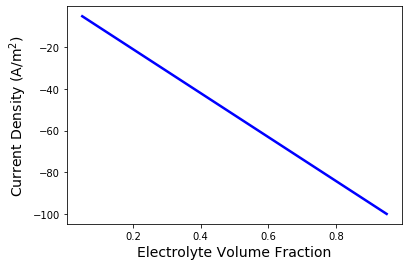

In [13]:
eps_array = np.linspace(0.05,0.95,25)

currents = np.zeros_like(eps_array)
for j, eps in enumerate(eps_array):
    geom['eps_e'] = eps
    N_k = electrolyte_transport(s1, s2, geom, e_pars)
    currents[j] = np.dot(e_pars['z_k'],N_k)*F
    
plt.plot(eps_array, currents,'b',linewidth=2.5)
plt.xlabel('Electrolyte Volume Fraction', fontsize=14)
plt.ylabel('Current Density (A/m$^2$)',fontsize=14)

### Discuss the results.  If you were designing a high-performance anode, what $\varepsilon_{\rm elyte}$ value would you pick?  Why?

According to the data, we would want a higher electrolyte volume fraction to achieve a higher current density.  This allows more transport.  In real life; however, the anode cannot be completely porus because you need surface area to react on.  This means there would be some tradeoff between electrolyte volume and the surface area of the reactant that we need to account for. Given this data, I would pick the highest number possible number which is 1.  More realistically, I think a number like 0.6-0.8 would be better?  I'd have to look at some papers to see.

## Part III. Charged defects in a proton-conducting ceramic:

The protonic ceramic membrane in this section has a fixed crystal lattice that can be occupied by one of three species:

- An oxygen atom, O$^\times$ (this is considered the neutral species)
- A vacancy,V$_{\rm O}^{\bullet\bullet}$ which has a charge of +2, relative to the oxygen
- An oxygen atom with a proton attached, OH$^\bullet$

The lattice site concentration is assumed fixed at 22,325 mol per m$^3$.

The vacancy and proton are considered mobile, while the oxide is considered fixed.  We will simulate transport at 600$^\circ$C, where the diffusion coefficients are:

- $D_{\rm V_{\rm O}^{\bullet\bullet}} = 1.28\times 10^{-12}\,\frac{\rm m^2}{\rm s}$
- $D_{\rm O^\times} = 0.0\,\frac{\rm m^2}{\rm s}$
- $D_{\rm OH^\bullet} = 7.46\times 10^{-11}\,\frac{\rm m^2}{\rm s}$

The membrane also has a small amount of electronic conductivity, $\sigma_{\rm el} = 0.001\,\frac{\rm S}{\rm m}$.

We will simulate transport between two nodes, which are 20 microns apart.  The conditions are:

1. Node 1:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.336$
- $X_{\rm O^\times} = 0.627$
- $X_{\rm OH^\bullet} = 0.037$
- $\phi_1 = 1.1$

2. Node 2:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.018$
- $X_{\rm O^\times} = 0.938$
- $X_{\rm OH^\bullet} = 0.044$
- $\phi_2 = 0.0$

## Enter the data, here:

In [14]:
C0 = 22325 #mol/m3
T = 600+273.15 #k
dY = 20e-6
X_Vo1 = 0.336
X_Ox1 = 0.627
X_Oh1 = 0.037
phi1 = 1.1
X_k1 = np.array([X_Vo1, X_Ox1, X_Oh1])

X_Vo2 = 0.018
X_Ox2 = 0.938
X_Oh2 = 0.044
phi2 = 0.
X_k2 = np.array([X_Vo2, X_Ox2, X_Oh2])

sig_el = 0.001 #S/m
conduct = 1/(sig_el)
# order = o,ox,oh
z = np.array([2., 0., 1.])
D_v = np.array([1.28E-12, 0., 7.46E-11])

s1 = {'X_k':X_k1,"phi":phi1, 'T':T}
s2 = {'X_k':X_k2,"phi":phi2, 'T':T}

geom = {'dy':dY}
ceramic_pars = {'z':z, 'D':D_v, 'C':C0, 'con':conduct}

## CREATE YOUR TRANSPORT FUNCTION HERE.

This function should return the fluxes, N_k, and the total current (ionic + electronic).

In [22]:
def protonic_transport(s1, s2, geom, ceramic_pars):
    C_avg = (s1['X_k']*ceramic_pars['C']+s2['X_k']*ceramic_pars['C'])/2.
    D_mig = D_v*C_avg*ceramic_pars['z']*F/(R*T)
    g_X =(s2['X_k']-s1['X_k'])/geom['dy']
    g_avg =((s1['X_k']+s2['X_k'])/2)
    N_k = - ceramic_pars['D']*C_avg*g_X/g_avg - D_mig*(s2['phi']-s1['phi'])/geom['dy'] 
    i_io = np.dot(N_k,ceramic_pars['z'])*F 
    i_el =(s2['phi']-s1['phi'])/geom['dy']/(ceramic_pars['con'])
    current = (i_io-i_el)
    print(current)
    return N_k, current

x = protonic_transport(s1, s2, geom, ceramic_pars)


5703.252757751884


## Here, we loop over a range of electric potential diffrerences between node 1 and node 2.

You do not need to do anything; just run the cell.

We will plot both the total current and the Faradaic efficiency, as a function of $\Delta \phi$.  

The Faradaic efficiency $\eta_{\rm Far}$ refers to the fact that the electronic leakage current is "undesired," for the protonic fuel cell.  We want all current to move ions across the membrane.  Therefore we find the efficiency as:
\begin{equation}
    \eta_{\rm Far} = \frac{i_{\rm ion}}{i_{\rm total}}
\end{equation}

31.43587915924999
88.72695874099412
146.01803832273703
203.30911790448116
260.6001974862253
317.89127706796944
375.18235664971235
432.47343623145645
489.76451581320066
547.0555953949435
604.3466749766876
661.6377545584318
718.9288341401754
776.2199137219188
833.510993303663
890.8020728854065
948.0931524671506
1005.384232048894
1062.6753116306381
1119.9663912123817
1177.2574707941253
1234.5485503758694
1291.8396299576132
1349.1307095393574
1406.4217891211006
1463.7128687028448
1521.0039482845887
1578.295027866332
1635.586107448076
1692.8771870298194
1750.168266611563
1807.4593461933073
1864.7504257750513
1922.041505356795
1979.3325849385385
2036.6236645202823
2093.914744102026
2151.2058236837693
2208.4969032655135
2265.7879828472574
2323.0790624290016
2380.3701420107445
2437.661221592489
2494.952301174232
2552.243380755976
2609.53446033772
2666.8255399194645
2724.1166195012074
2781.4076990829512
2838.6987786646955
2895.989858246439
2953.280937828183
3010.5720174099265
3067.8630969916703

(99, 100)

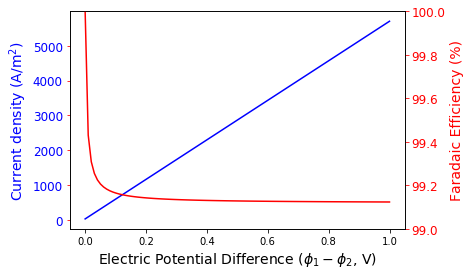

In [24]:
dPhi = np.linspace(0.0, 1.0, 100)
eta_Far = np.zeros_like(dPhi)
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    Nk, i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)
    i_ion = np.dot(Nk,ceramic_pars['z'])*F
    
    eta_Far[j] = 100*i_ion/i_tot[j]
    
    
# Plot the results:
fig, ax = plt.subplots()
plt.plot(dPhi, i_tot,color='b')

# Create a 2nd y axis:
ax2 = ax.twinx()
ax2.plot(dPhi, eta_Far,'r')

# Formatting:
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, V)', fontsize=14)

ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)
ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)

ax2.set_ylabel('Faradaic Efficiency (%)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.set_ylim((99,100))

## In this markdown cell, discuss the plot.  What explains the trends?

To check your answers, your total current should go from roughly zero at $\Delta\phi = 0$, to nearly 6000 A/m$^2$ at $\Delta\phi = 1.0.$ Over the same range, the Faradaic efficiency should go from 100% to roughly 99.1%.

Well the Faradaic efficiency doesn't change which is sad.  However, imagining that it did, this is because as the voltage increases, the current needed to overcome the resistance (I'm not sure if this is a good way to put it but it works for me) gets bigger.

### Now loop over a smaller range of potentials, to see where we get a net current of zero.

(you do not need to type anything; just run the cell).

-24.782279626676416
-18.86457870184178
-12.946877777007161
-7.029176852173779
-1.1114759273391723
4.806224997495455
10.72392592233006
16.64162684716469
22.559327771998063
28.47702869683268
34.394729621667295
40.312430546501915
46.23013147133529
52.14783239616991
58.065533321004516
63.983234245839135
69.90093517067375
75.81863609550715
81.73633702034176
87.65403794517638


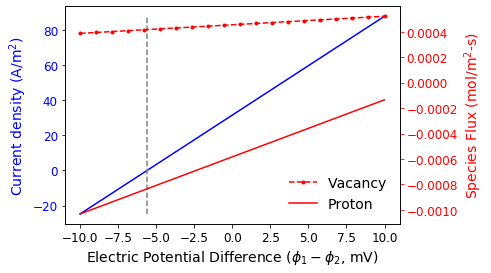

In [66]:
dPhi = np.linspace(-0.01, 0.01, 20)
N_k = np.zeros((len(dPhi),len(s1['X_k'])))
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    N_k[j,:], i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)

fig, ax = plt.subplots()
plt.plot(1000*dPhi, i_tot,color='b')

zero = 1000*np.interp(0,i_tot,dPhi)
plt.plot([zero,zero],[i_tot[0],i_tot[-1]],'--',color='0.5')

ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)

ax.tick_params(axis='x',color='k',labelcolor='k',labelsize=12)
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, mV)', fontsize=14)
# ax.set_xlim((-0.01,0.01))

ax2 = ax.twinx()
ax2.plot(1000*dPhi, N_k[:,0],'r.--')
ax2.plot(1000*dPhi, N_k[:,2],color='r')

ax2.set_ylabel('Species Flux (mol/m$^2$-s)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)

ax2.legend(['Vacancy','Proton'],fontsize=14,frameon=False)

### Discuss the result.  Is the 'zero current' condition the same as for the battery anode?  

No, the zero current condition is not the same, because in this case the ions have different charges and different diffusion coefficients.  Furthermore, we had added the effects of the electric current.  This makes the "zero current" condition occur at a different potential.